In [1]:
from rkcca import *

import numpy as np
import collections
import matplotlib.pyplot as plt
from graspy.plot import pairplot
%matplotlib inline
import seaborn as sns
import math

from mvlearn.datasets.GaussianMixture import GaussianMixture

%load_ext autoreload
%autoreload 2

In [36]:
def make_data(kernel, N, seeds=[None, None]):
    ## Define two latent variables (number of samples x 1)
    np.random.seed(seeds[0])
    latvar1 = np.random.randn(N,)
    np.random.seed(seeds[1])
    latvar2 = np.random.randn(N,)
    
    ## Define independent components for each dataset (number of observations x dataset dimensions)
    indep1 = np.random.randn(N, 4)
    indep2 = np.random.randn(N, 5)
    #indep2 = np.random.randn(N, 4)
    
    if kernel == "linear":
        #x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
        #y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, 0*latvar1, 0*latvar2)).T
        y = 0.25*indep2 + -0.75*np.vstack((latvar1, latvar2, 0*latvar1, 0*latvar2)).T
        
        return [x,y]
    
    elif kernel == "poly":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, latvar1**2, latvar2**2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        #x = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, 0*latvar1, 0*latvar2)).T
        #y = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, 0*latvar1**2, 0*latvar2**2)).T
        
        return [x,y]
    
    elif kernel == "gaussian":
        np.random.seed(seeds[0])
        t = np.random.uniform(-np.pi, np.pi, N)
        e1 = np.random.normal(0, 0.05, (N,2))
        e2 = np.random.normal(0, 0.05, (N,2))
        
        x = np.zeros((N,2))
        x[:,0] = t
        x[:,1] = np.sin(3*t)
        x += e1
        
        y = np.zeros((N,2))
        y[:,0] = np.exp(t/4)*np.cos(2*t)
        y[:,1] = np.exp(t/4)*np.sin(2*t)
        y += e2
        
        return [x,y]
    
def plot_components(components, labels=None):
    # We plot dimensions of both views to further show that the first two dimensions are linearly correlated ideally
    n_dim = components[0].shape[1]
    fig,axes = plt.subplots(n_dim,n_dim,figsize=(8,8))#, sharex=True, sharey=True)
    for i,ax in enumerate(axes.flatten()):
        dim2 = int(i/n_dim)
        dim1 = i % n_dim
        if not labels is None:
            ax.scatter(components[0][:,dim1],components[1][:,dim2], c=labels, alpha=0.2)
        else:
            ax.scatter(components[0][:,dim1],components[1][:,dim2])
        if dim2 == n_dim-1:
            ax.set_xlabel(f'View 1 Component {dim1+1}')
        if dim1 == 0:
            ax.set_ylabel(f'View 2 Component {dim2+1}')
        ax.axis('equal')
        #ax.set_xticks([])

    plt.show()

In [108]:
## Training
n = 200
mu = [[0,1], [0,-1]]
sigma = 10*[np.eye(2), np.eye(2)]
pi = [0.5,0.5]
GM = GaussianMixture(n,mu,sigma,class_probs=pi)

## Test
GM2 = GaussianMixture(n,mu,sigma,class_probs=pi)

## Poly

In [24]:
method = 'poly'

In [37]:
Xs_train = make_data(method, 200, seeds=[1,2])
Xs_test = make_data(method, 200, seeds=[1,2])

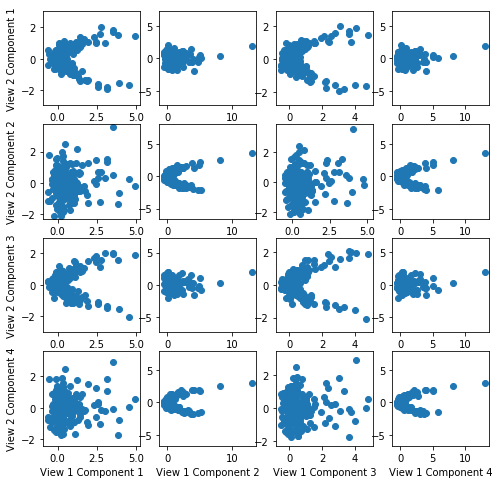

In [38]:
plot_components(Xs_train)

In [57]:
components = kcca(Xs_train, reg=0.0000001, numCC=4, kernelcca=True, ktype=method, gausigma=1.0, degree=2)

In [58]:
kernels = [make_kernel(d, ktype=method, gausigma=1.0, degree=2) for d in Xs_test]

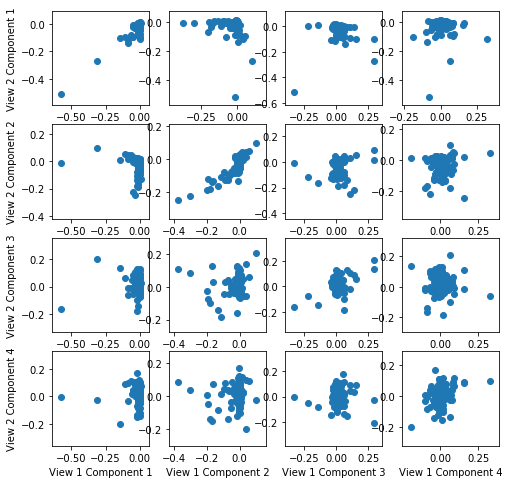

In [59]:
plot_components([k@c for k,c in zip(kernels, components)])

## Gaussian

In [127]:
method = 'gaussian'

In [101]:
Xs_train = make_data(method, 200, seeds=[1,2])
Xs_test = make_data(method, 200, seeds=[1,2])

In [102]:
angles = np.random.uniform(0,2*math.pi,100)

X1 = np.asarray([[2 * math.cos(a), 2 * math.sin(a)] for a in angles]) + np.random.normal(0,0.1,size=(100,2))
X2 = np.asarray([[a - math.pi, math.sin(a)] for a in angles]) + np.random.normal(0,0.1,size=(100,2))

Xs_train = [X1, X2]

X1 = np.asarray([[2 * math.cos(a), 2 * math.sin(a)] for a in angles]) + np.random.normal(0,0.1,size=(100,2))
X2 = np.asarray([[a - math.pi, math.sin(a)] for a in angles]) + np.random.normal(0,0.1,size=(100,2))

Xs_test = [X1, X2]

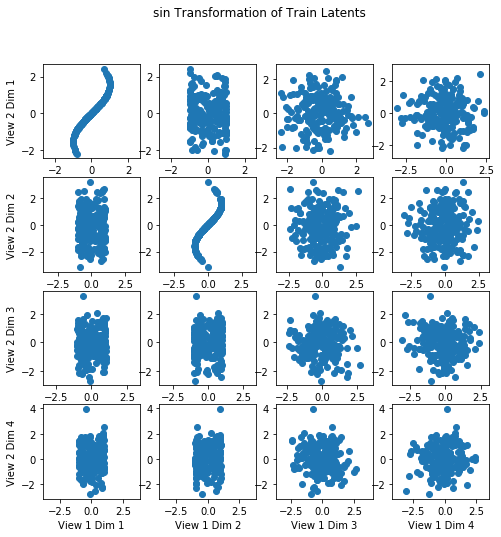

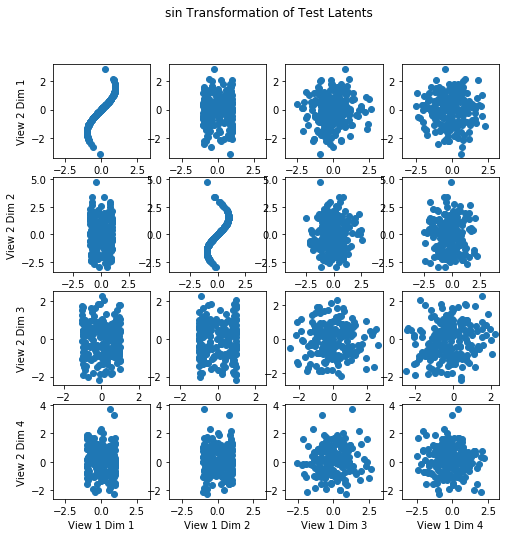

In [110]:
n_noise = 2
transform='sin'
GM.sample_views(transform=transform, n_noise=n_noise, random_states=[0,1])
GM2.sample_views(transform=transform, n_noise=n_noise, random_states=[2,3])

# Plot 2 views of training data
GM.plot_2views(title=f'{transform} Transformation of Train Latents', figsize=(8,8))
GM2.plot_2views(title=f'{transform} Transformation of Test Latents', figsize=(8,8))

Xs_train = GM.Xs
Xs_test = GM2.Xs

In [124]:
components = kcca(Xs_train, reg=0.0001, numCC=4, kernelcca=True, ktype=method, gausigma=1.0, degree=2)

In [125]:
kernels = [make_kernel(d, ktype=method, gausigma=1.0, degree=2) for d in Xs_test]

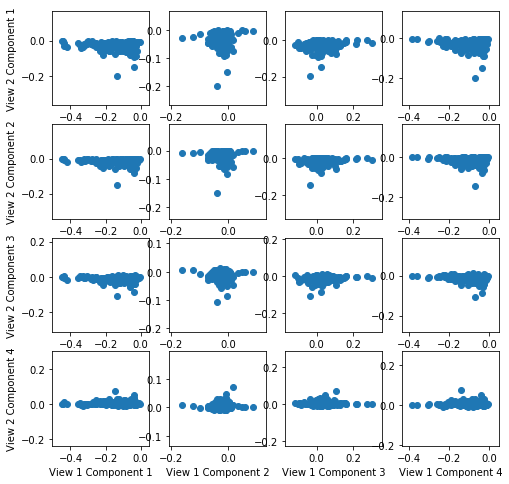

In [126]:
plot_components([k@c for k,c in zip(kernels, components)])